# Work with TMDB + IMDB dataset 
- [Source](https://www.kaggle.com/datasets/alanvourch/tmdb-movies-daily-updates)

**Metadata**

| **Column**               | **Description**                                                                                     |
|--------------------------|-----------------------------------------------------------------------------------------------------|
| **id**                   | Unique identifier for the film in the dataset.                                                     |
| **title**                | The title of the film.                                                                             |
| **vote_average**         | Average rating of the film based on user votes (out of 10).                                        |
| **vote_count**           | Total number of votes cast for the film.                                                           |
| **status**               | The current release status of the film (e.g., *Released*, *Post-Production*).                      |
| **release_date**         | The date when the film was released.                                                              |
| **revenue**              | The total revenue generated by the film (in USD).                                                 |
| **runtime**              | The length of the film in minutes.                                                                |
| **budget**               | The production budget for the film (in USD).                                                      |
| **imdb_id**              | Unique identifier for the film on IMDb.                                                           |
| **overview**             | A brief description or synopsis of the film’s plot.                                                |
| **popularity**           | A numeric score representing the popularity of the film (based on an internal calculation).        |
| **genres**               | The genre(s) of the film (e.g., Comedy, Drama).                                                   |
| **production_companies** | List of production companies involved in the making of the film.                                   |
| **production_countries** | The country or countries where the film was produced.                                             |
| **spoken_languages**     | The language(s) spoken in the film.                                                               |
| **director**             | Name of the film’s director.                                                                      |
| **producers**            | Names of the producers involved in the film.                                                     |
| **imdb_rating**          | IMDb user rating of the film (out of 10).                                                         |
| **imdb_votes**           | Number of votes received by the film on IMDb.                                                    |



In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
import langcodes


In [2]:
import sys
sys.path.append('../utils')
import functions

In [3]:
tmdb_df = pd.read_csv('../data/local/raw/TMDB_all_movies.csv')

In [4]:
functions.show_basic_info(tmdb_df)


DataFrame Shape: (1028026, 28)
Number of Rows: 1028026
Number of Columns: 28

Data Types of Columns:
id                           int64
title                       object
vote_average               float64
vote_count                 float64
status                      object
release_date                object
revenue                    float64
runtime                    float64
budget                     float64
imdb_id                     object
original_language           object
original_title              object
overview                    object
popularity                 float64
tagline                     object
genres                      object
production_companies        object
production_countries        object
spoken_languages            object
cast                        object
director                    object
director_of_photography     object
writers                     object
producers                   object
music_composer              object
imdb_rating            

In [5]:
# functions.show_column_summary(tmdb_df)

Columns to drop:
- cast
- director_of_photography
- music_composer
- poster_path
- writers
- tagline

In [6]:
tmdb_df.drop(columns=['cast', 'director_of_photography', 'music_composer', 'poster_path', 'writers', 'tagline'], inplace=True)
tmdb_df.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,overview,popularity,genres,production_companies,production_countries,spoken_languages,director,producers,imdb_rating,imdb_votes
0,2,Ariel,7.1,335.0,Released,1988-10-21,0.0,73.0,0.0,tt0094675,...,After the coal mine he works at closes and his...,11.915,"Comedy, Drama, Romance, Crime",Villealfa Filmproductions,Finland,suomi,Aki Kaurismäki,Aki Kaurismäki,7.4,8812.0
1,3,Shadows in Paradise,7.3,369.0,Released,1986-10-17,0.0,74.0,0.0,tt0092149,...,"Nikander, a rubbish collector and would-be ent...",16.287,"Comedy, Drama, Romance",Villealfa Filmproductions,Finland,"suomi, English, svenska",Aki Kaurismäki,Mika Kaurismäki,7.5,7587.0
2,5,Four Rooms,5.8,2628.0,Released,1995-12-09,4257354.0,98.0,4000000.0,tt0113101,...,It's Ted the Bellhop's first night on the job....,21.312,Comedy,"Miramax, A Band Apart",United States of America,English,"Quentin Tarantino, Robert Rodriguez, Alexandre...","Quentin Tarantino, Alexandre Rockwell, Lawrenc...",6.7,112798.0
3,6,Judgment Night,6.5,331.0,Released,1993-10-15,12136938.0,109.0,21000000.0,tt0107286,...,"Four young friends, while taking a shortcut en...",8.924,"Action, Crime, Thriller","Largo Entertainment, JVC, Universal Pictures",United States of America,English,Stephen Hopkins,"Gene Levy, Lloyd Segan, Marilyn Vance",6.6,19361.0
4,8,Life in Loops (A Megacities RMX),7.5,27.0,Released,2006-01-01,0.0,80.0,42000.0,tt0825671,...,Timo Novotny labels his new project an experim...,3.203,Documentary,inLoops,Austria,"English, हिन्दी, 日本語, Pусский, Español",Timo Novotny,"Ulrich Gehmacher, Timo Novotny",8.2,284.0


In [7]:
functions.check_for_duplicates(tmdb_df)


No duplicate rows found in the DataFrame.


Remove all rows where 'status' is not 'Released'

In [8]:
print(tmdb_df['status'].unique())

['Released' 'Rumored' 'Post Production' 'Canceled' 'Planned'
 'In Production' nan]


In [9]:
initial_rows = len(tmdb_df)
tmdb_df = tmdb_df[tmdb_df['status'] == 'Released'] # keep rows where 'status' is 'Released'
final_rows = len(tmdb_df)
removed_rows = initial_rows - final_rows
print(f'Number of rows removed: {removed_rows}')

Number of rows removed: 16758


#### 'release_date' column
- Convert to datetime
- Extract year only
- Convert year to integer

In [10]:
df = tmdb_df.copy()

In [11]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year.astype('Int64')
print(df[['release_date', 'release_year']].head())

  release_date  release_year
0   1988-10-21          1988
1   1986-10-17          1986
2   1995-12-09          1995
3   1993-10-15          1993
4   2006-01-01          2006


Get released movie count per year in df

In [12]:
release_year_counts = df['release_year'].value_counts().sort_index()
print(release_year_counts)

release_year
1800        1
1865        1
1874        1
1878       31
1882        1
        ...  
2022    41950
2023    47546
2024    44390
2025      194
2026        1
Name: count, Length: 147, dtype: Int64


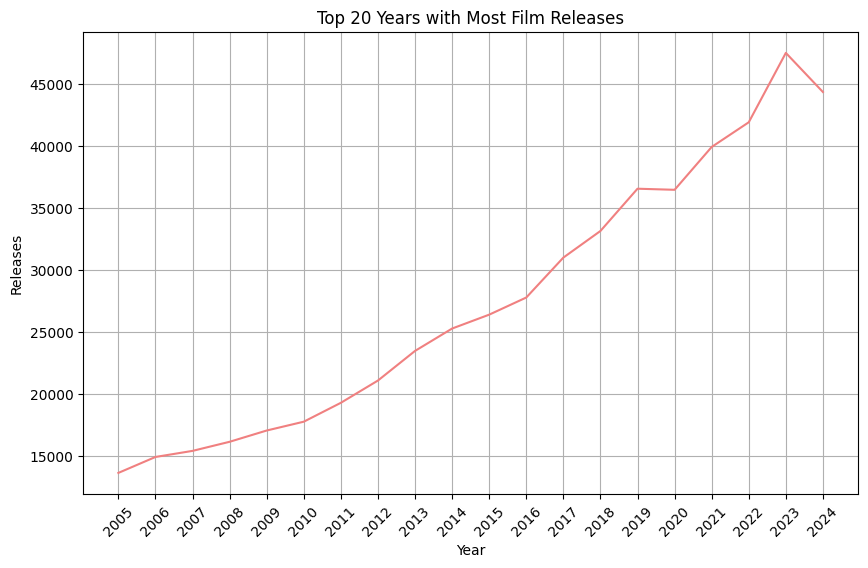

In [13]:
release_year_counts = df['release_year'].value_counts().sort_index()

top_20_years = release_year_counts.nlargest(20).sort_index()

top_20_years.index = top_20_years.index.astype(str)

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=top_20_years.index, y=top_20_years.values, color='lightcoral')

plt.title('Top 20 Years with Most Film Releases')
plt.xlabel('Year')
plt.ylabel('Releases')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

### Create new DF from one specific year

In [14]:
df_2018 = df[df['release_year'] == 2018]

df_2018 = df_2018.reset_index(drop=True)

print(f'Number of rows in the 2018 dataset: {len(df_2018)}')

Number of rows in the 2018 dataset: 33181


In [15]:
df_2018.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,popularity,genres,production_companies,production_countries,spoken_languages,director,producers,imdb_rating,imdb_votes,release_year
0,10148,Krystal,5.2,56.0,Released,2018-04-13,0.0,90.0,0.0,tt0835802,...,4.910,"Drama, Comedy","Dog Pond Productions, Dorian Media, Pantry Fil...",United States of America,English,William H. Macy,"Rachel Rothman, Robert Halmi Jr., Dan Keston, ...",5.5,1773.0,2018
1,42330,Monkey Magic,6.0,3.0,Released,2018-09-22,0.0,66.0,0.0,tt10443316,...,20.359,"Animation, Fantasy, Adventure",NaN,China,普通话,Jihai Ma,NaN,6.4,31.0,2018
2,45033,20 Seconds of Joy,8.0,2.0,Released,2018-01-01,0.0,60.0,337200.0,tt1202339,...,2.720,Documentary,"F24 Film, Red Bull Media House",Germany,Deutsch,Jens Hoffmann,Cleonice Comino,7.5,152.0,2018
3,46677,Oliver Tambo: Have You Heard From Johannesburg,0.0,0.0,Released,2018-02-01,0.0,97.0,0.0,tt7954272,...,0.600,Documentary,NaN,United States of America,English,Connie Field,NaN,NaN,NaN,2018
4,50022,Super Troopers 2,5.9,461.0,Released,2018-04-19,31626386.0,100.0,13500000.0,tt0859635,...,10.217,"Comedy, Crime, Mystery","Broken Lizard Industries, Cataland Films, Need...",United States of America,"English, Português",Jay Chandrasekhar,"Michael Hassan, Kris Meyer, Charles Stiefel, J...",6.0,28791.0,2018


Drop Columns
- 'id'
- 'imdb_id'
- 'overview'
- 'production_companies'
- 'production_countries'
- 'producers'
- 'release_date'
- 'spoken_languages'
- 'status'
- 'vote_average'
- 'vote_count'

In [16]:
# Drop specified columns
columns_to_drop = ['id', 'imdb_id', 'overview', 'production_companies', 'production_countries', 'producers', 'release_date', 'spoken_languages', 'status', 'vote_average', 'vote_count']

df_2018 = df_2018.drop(columns=columns_to_drop)

In [17]:
df_2018['clean_title'] = functions.prepare_clean_titles(df_2018, 'title')

# reorder columns
df_2018 = df_2018[['title', 'original_title', 'clean_title', 'release_year', 'imdb_rating', 'imdb_votes', 'genres', 'director', 'revenue', 'budget', 'runtime', 'original_language', 'popularity']]

In [18]:
# clean genres
df_2018['genres'] = functions.clean_genres(df_2018, 'genres')
df_2018.head()

,title,original_title,clean_title,release_year,imdb_rating,imdb_votes,genres,director,revenue,budget,runtime,original_language,popularity
0,Krystal,Krystal,krystal,2018,5.5,1773.0,"drama, comedy",William H. Macy,0.0,0.0,90.0,en,4.910
1,Monkey Magic,大闹西游,monkey magic,2018,6.4,31.0,"animation, fantasy, adventure",Jihai Ma,0.0,0.0,66.0,zh,20.359
2,20 Seconds of Joy,20 Seconds of Joy,20 seconds of joy,2018,7.5,152.0,documentary,Jens Hoffmann,0.0,337200.0,60.0,de,2.720
3,Oliver Tambo: Have You Heard From Johannesburg,Oliver Tambo: Have You Heard From Johannesburg,oliver tambo have you heard from johannesburg,2018,NaN,NaN,documentary,Connie Field,0.0,0.0,97.0,en,0.600
4,Super Troopers 2,Super Troopers 2,super troopers 2,2018,6.0,28791.0,"comedy, crime, mystery",Jay Chandrasekhar,31626386.0,13500000.0,100.0,en,10.217


In [19]:
# float columns to int

columns_to_convert = ['imdb_votes', 'revenue', 'budget', 'runtime']

df_2018[columns_to_convert] = df_2018[columns_to_convert].astype('Int64', errors='ignore')

df_2018.head()

,title,original_title,clean_title,release_year,imdb_rating,imdb_votes,genres,director,revenue,budget,runtime,original_language,popularity
0,Krystal,Krystal,krystal,2018,5.5,1773,"drama, comedy",William H. Macy,0,0,90,en,4.910
1,Monkey Magic,大闹西游,monkey magic,2018,6.4,31,"animation, fantasy, adventure",Jihai Ma,0,0,66,zh,20.359
2,20 Seconds of Joy,20 Seconds of Joy,20 seconds of joy,2018,7.5,152,documentary,Jens Hoffmann,0,337200,60,de,2.720
3,Oliver Tambo: Have You Heard From Johannesburg,Oliver Tambo: Have You Heard From Johannesburg,oliver tambo have you heard from johannesburg,2018,NaN,<NA>,documentary,Connie Field,0,0,97,en,0.600
4,Super Troopers 2,Super Troopers 2,super troopers 2,2018,6.0,28791,"comedy, crime, mystery",Jay Chandrasekhar,31626386,13500000,100,en,10.217


In [20]:
# Check empty rows
total_rows = len(df_2018)

empty_rows = df_2018.isna().any(axis=1).sum()

print(f'Total number of rows: {total_rows}')
print(f'Number of rows with empty values: {empty_rows}')


Total number of rows: 33181
Number of rows with empty values: 20905


In [ ]:
df_2018['language'] = df_2018['original_language'].apply(functions.get_language_name)

df_2018.head()

,title,original_title,clean_title,release_year,imdb_rating,imdb_votes,genres,director,revenue,budget,runtime,original_language,popularity,language
0,Krystal,Krystal,krystal,2018,5.5,1773,"drama, comedy",William H. Macy,0,0,90,en,4.910,English
1,Monkey Magic,大闹西游,monkey magic,2018,6.4,31,"animation, fantasy, adventure",Jihai Ma,0,0,66,zh,20.359,Chinese
2,20 Seconds of Joy,20 Seconds of Joy,20 seconds of joy,2018,7.5,152,documentary,Jens Hoffmann,0,337200,60,de,2.720,German
3,Oliver Tambo: Have You Heard From Johannesburg,Oliver Tambo: Have You Heard From Johannesburg,oliver tambo have you heard from johannesburg,2018,NaN,<NA>,documentary,Connie Field,0,0,97,en,0.600,English
4,Super Troopers 2,Super Troopers 2,super troopers 2,2018,6.0,28791,"comedy, crime, mystery",Jay Chandrasekhar,31626386,13500000,100,en,10.217,English


### Top 10s

In [ ]:
# For most popular genres:
# Split the 'genres' column by commas and explode it to create a new row for each genre
df_exploded_genres = df_2018['genres'].str.split(',').explode().str.strip()

# Add the 'popularity' column to the exploded genres
df_genres_popularity = df_exploded_genres.to_frame(name='genre').join(df_2018['popularity'])

# Group by genre and calculate average popularity
genre_popularity = df_genres_popularity.groupby('genre')['popularity'].mean().sort_values(ascending=False)

# Display top 10 most popular genres
print('Most Popular Genres:')
print(genre_popularity.head(10))

# For most popular languages:
# Group by 'original_language' and calculate average popularity
language_popularity = df_2018.groupby('language')['popularity'].mean().sort_values(ascending=False)

# Display top 10 most popular languages
print('\nMost Popular Languages:')
print(language_popularity.head(10))


Most Popular Genres:
genre
adventure          7.145405
action             5.701479
science fiction    5.027279
fantasy            4.290015
thriller           4.242878
crime              3.951117
family             3.880084
romance            3.795598
tv movie           3.736438
mystery            3.497254
Name: popularity, dtype: float64

Most Popular Languages:
language
Korean                   3.910178
Swahili                  3.537429
Akan                     2.828000
Hindi                    2.780410
Unknown language [cn]    2.578329
Basque                   2.538667
Aymara                   2.178000
Telugu                   2.124395
Tamil                    2.110740
Somali                   2.084000
Name: popularity, dtype: float64


In [ ]:
# Split the 'genres' column by commas and explode it to create a new row for each genre
df_exploded_genres = df_2018['genres'].str.split(',').explode().str.strip()

# Add the 'popularity' column to the exploded genres
df_genres_imdb_rating = df_exploded_genres.to_frame(name='genre').join(df_2018['imdb_rating'])

# Group by genre and calculate average imdb_rating
genre_imdb_rating = df_genres_imdb_rating.groupby('genre')['imdb_rating'].mean().sort_values(ascending=False)

# Display top 10 most popular genres
print('Most Popular Genres:')
print(genre_imdb_rating.head(10))

# For most popular languages:
# Group by 'original_language' and calculate average imdb_rating
language_imdb_rating = df_2018.groupby('language')['imdb_rating'].mean().sort_values(ascending=False)

# Display top 10 most popular languages
print('\nMost Popular Languages:')
print(language_popularity.head(10))

Most Popular Genres:
genre
documentary    7.087078
music          6.992273
history        6.802632
animation      6.609834
war            6.406098
drama          6.296974
tv movie       6.113284
romance        6.039286
family         6.031022
fantasy        5.994477
Name: imdb_rating, dtype: float64

Most Popular Languages:
language
Korean                   3.910178
Swahili                  3.537429
Akan                     2.828000
Hindi                    2.780410
Unknown language [cn]    2.578329
Basque                   2.538667
Aymara                   2.178000
Telugu                   2.124395
Tamil                    2.110740
Somali                   2.084000
Name: popularity, dtype: float64


### Correlations

In [37]:
# 1. Calculate correlations for numeric columns
numeric_columns = ['popularity', 'revenue', 'budget', 'runtime', 'imdb_rating', 'imdb_votes']
correlation_matrix = df_2018[numeric_columns].corr()

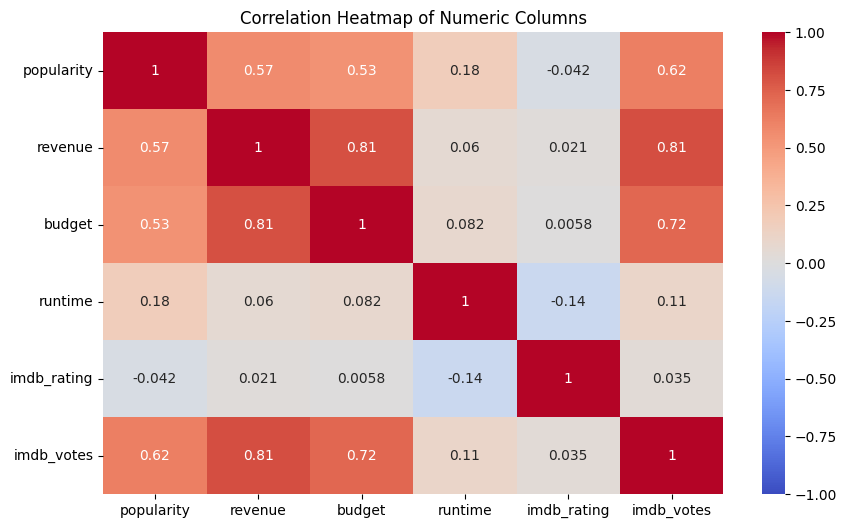

In [38]:
# 2. Plot correlation matrix heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

In [39]:
# 3. Top 10 or 20 most popular genres
# For genres, split and explode the genres column
df_exploded_genres = df_2018['genres'].str.split(',').explode().str.strip()
df_genres_popularity = df_exploded_genres.to_frame(name='genre').join(df_2018['popularity'])

In [40]:
# Group by genre and calculate average popularity
genre_popularity = df_genres_popularity.groupby('genre')['popularity'].mean().sort_values(ascending=False)
top_20_genres = genre_popularity.head(20)

/tmp/ipykernel_144193/3801290837.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_genres.values, y=top_20_genres.index, palette='viridis')


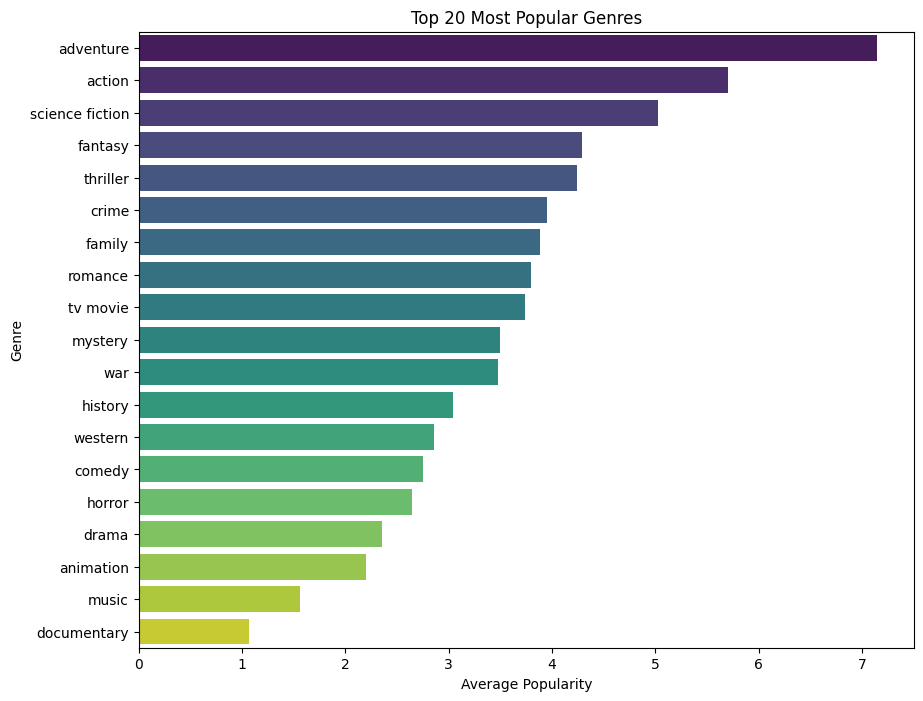

In [44]:
# Plot the top 20 most popular genres
plt.figure(figsize=(10, 8))
sns.barplot(x=top_20_genres.values, y=top_20_genres.index, palette='viridis')
plt.title('Top 20 Most Popular Genres')
plt.xlabel('Average Popularity')
plt.ylabel('Genre')
plt.show()

In [42]:
# 4. Top 10 most popular languages
language_popularity = df_2018.groupby('language')['popularity'].mean().sort_values(ascending=False)
top_10_languages = language_popularity.head(10)

/tmp/ipykernel_144193/4234165024.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_languages.values, y=top_10_languages.index, palette='magma')


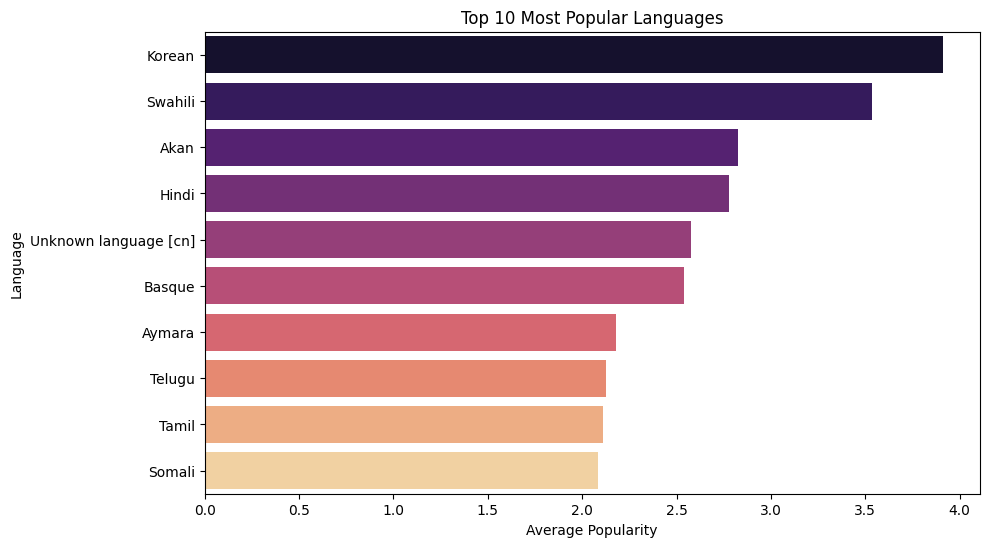

In [43]:
# Plot the top 10 most popular languages
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_languages.values, y=top_10_languages.index, palette='magma')
plt.title('Top 10 Most Popular Languages')
plt.xlabel('Average Popularity')
plt.ylabel('Language')
plt.show()